# 15.4. 긴 시퀀스 다루기

## 긴 시퀀스란?
- 긴 시계열, 텍스트, 오디오 등
- 예시: 언어 모델을 통해 다음에 올 단어를 예측하는 작업(긴 문장)
- "**모스크바**에 여행을 왔는데 건물도 예쁘고 먹을 것도 맛있었어. 그런데 글쎄 직장 상사한테 전화가 왔어. 어디냐고 묻더라구 그래서 나는 말했지. 저 여행왔는데요. 여기 ___"

## 심층 RNN
- 심층신경망(Deep Neural Network; DNN)처럼 그래디언트 소실과 폭주 문제를 가질 수 있음
  - 신경망 하위층으로 갈수록 그래디언트가 점점 작아지거나 커지는 현상
  - 모델 학습 시간 장기화 & 불안정

## 15.4.1. 불안정한 그래디언트 문제
- DNN: 가중치 초기화(글로럿|르쿤), 수렴하지 않는 활성화함수(ReLU|LeakyReLU), 배치정규화, 그래디언트 클리핑, 옵티마이저(모멘텀 최적화|네스테로프 가속경사...), 드롭아웃
- RNN: 문제 해결방법에 있어서 DNN과 차이있는 부분들이 존재

### 1. 수렴하지 않는 활성화함수 -> 수렴하는 활성화함수 
- 수렴하지 않는 활성화함수(ReLU)는 오히려 불안정한 원인
- 수렴하는 활성화함수(하이퍼볼릭 탄젠트 Hyperbolic tangent; tanh) 사용이 더 적절
- 또는 그래디언트 클리핑을 적용하여 문제 완화

In [3]:
# Plot tanh
import numpy as np
import plotly.express as px

x = np.linspace(-4, 4, 128)
y = np.tanh(x)

fig = px.scatter(x = x, y = y)
fig.show()

### 2. 배치정규화 -> 층정규화(Layer Normalization)
- 배치정규화: 배치 차원에 대해 정규화
- 층정규화: 특성 차원에 대해 정규화
- 일반적으로 입력(inputs)과 은닉상태(states)의 선형 조합 직후에 적용

In [8]:
# Build layer normalization (LN)
from tensorflow import keras

class LN_SimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation = 'tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size  = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation = None)
        self.layer_norm      = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states) # 입력과 은닉상태의 선형 조합(단, 여기서 outputs = new_states[0]하게 계산됨)
        norm_outputs        = self.activation(self.layer_norm(outputs)) # 층정규화 적용 후 활성화함수 적용
        return norm_outputs, [norm_outputs]


model = keras.models.Sequential([
    keras.layers.RNN(LN_SimpleRNNCell(20), return_sequences = True, input_shape = [None, 1]),
    keras.layers.RNN(LN_SimpleRNNCell(20), return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, None, 20)          480       
_________________________________________________________________
rnn_1 (RNN)                  (None, None, 20)          860       
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 1,550
Trainable params: 1,550
Non-trainable params: 0
_________________________________________________________________


### 3. 드롭아웃(TensorFlow Keras 기준 매개변수)
- dropout: 타임스텝마다 입력에 적용되는 드롭아웃 비율
- recurrent_dropout: 타임스텝마다 은닉상태에 적용되는 드롭아웃 비율

In [ ]:
tf.keras.layers.SimpleRNNCell(
    units, activation='tanh', use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros', kernel_regularizer=None,
    recurrent_regularizer=None, bias_regularizer=None, kernel_constraint=None,
    recurrent_constraint=None, bias_constraint=None, dropout=0.0,
    recurrent_dropout=0.0, **kwargs
)

## 15.4.2. 단기 기억 문제
- RNN cell을 거치면서 일부 정보는 매 타임스텝마다 사라짐
- "**모스크바**에 여행을 왔는데 건물도 예쁘고 먹을 것도 맛있었어. 그런데 글쎄 직장 상사한테 전화가 왔어. 어디냐고 묻더라구 그래서 나는 말했지. 저 여행왔는데요. 여기 ___"
- "모스크바"에 대한 정보를 기억하지 못할 수 있음(단기 기억 문제)
- 장기(Long term) 메모리의 등장


### LSTM (Long Short-Term Memory)
- Long short-term memory (Sepp Hochreiter and Jürgen Schmidhuber, 1997)에서 처음 소개됨
- 이후 여러 연구자들을 거쳐 향상

In [9]:
# Build LSTM
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences = True, input_shape = [None, 1]),
    keras.layers.LSTM(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 20)          1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 10)          210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


### LSTM 구조
- h(t): 단기 상태(Short-term state)
- c(t): 장기 상태(Long-term state)
- 핵심: 장기 상태에 저장할 것(입력), 버릴 것(삭제), 읽어들일 것(출력)을 학습
  - 3 종류의 게이트 제어기 모두 로지스틱 활성화함수를 사용(0 ~ 1 범위)
  - 삭제 게이트(forget gate): 장기 상태의 어느 부분이 삭제되어야 하는지 제어
  - 입력 게이트(input gate) : 주 층(g(t))의 어느 부분이 장기 상태에 더해져야 하는지 제어
  - 출력 게이트(output gate): 장기 상태의 어느 부분을 읽어서 h(t), y(t)로 출력해야 하는지 제어
- 긴 시퀀스에 대해 좋은 성능을 보임

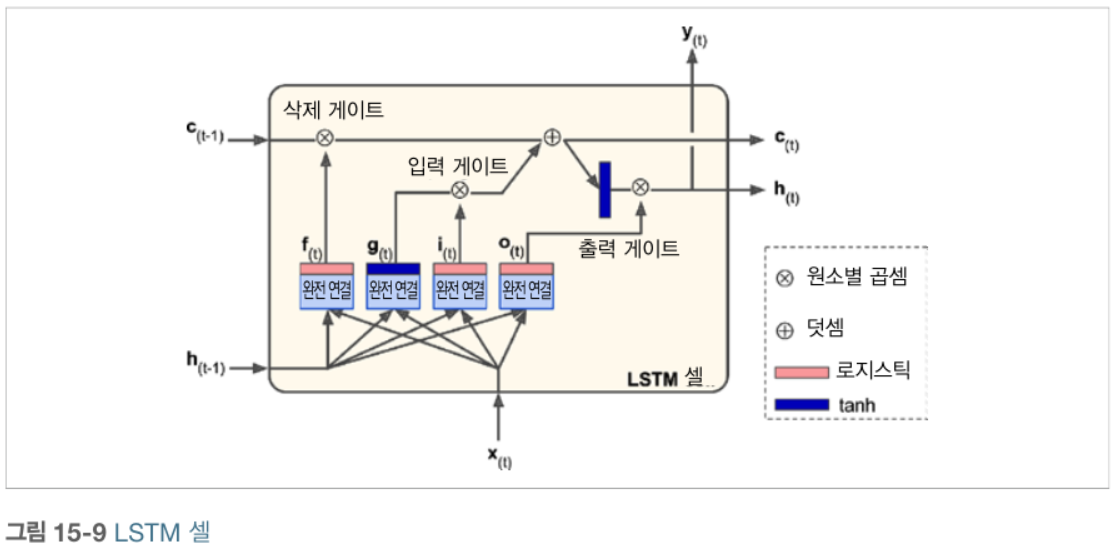

In [10]:
from IPython.display import Image

Image('./lstm_cell.png')

### 핍홀 연결(LSTM 변종)
- 일반 LSTM: 게이트 제어기가 입력 x(t), 이전 단기 상태 h(t-1)만 참고(tf.keras.layers.LSTMCell)
- 핍홀 연결(Peephole connection): 게이트 제어기가 입력 x(t), h(t-1) 뿐만 아니라 장기 상태 c(t-1) 또는 c(t)도 참고(tf.keras.experimental.PeepholeLSTMCell)

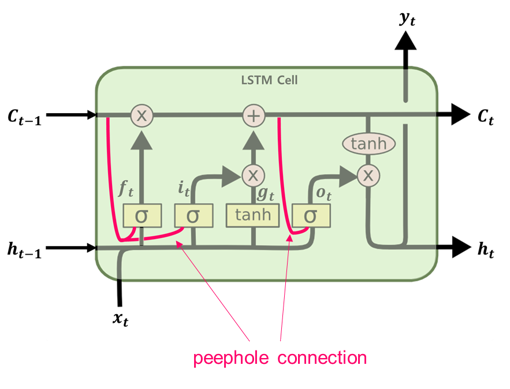

In [1]:
from IPython.display import Image

Image('./peephole_connection.png')